# Tutorial For Creating A Time-Series From ICON-Outputs

This is a small tutorial for how to use the ICON_TS class to generate a time series of statistical values (mean, std etc.) from all files and time steps during an ICON simulation.

In [9]:
import glob
import geopandas as gpd
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')

# Import the time series class from its file. It internally relies on the imesh class from the icon2vtk file so this needs to be available
from ICON_Time_Series import ICON_TS

You need to provide the following paths to the class constructor:

* A list of filepaths which point to the ICON output file (.nc)
* A path to the external parameter file used
* A path tohe grid file describing the geometry
* A polygon file used to limit the area for which the time series will be computed (for example the area of the Hintereisferner from RGI)

In [10]:
# set path to dir containing the ICON output files
filepaths = glob.glob(r"G:\NCs\*.nc") # Here we use a directory with six ICON outputs
print(filepaths)

# Adapt paths to the location of the files with external parameters and grid
fext = r"../../Data/external_parameter_icon_hef_DOM01_tiles.nc"
fgrid = r"../../Data/hef_51m_DOM01.nc"

# Set path to the polygon used to limit the grid (glacier shp or else)
gdf = gpd.read_file("../../Data/test.shp")
polygon = gdf.geometry.union_all()  # merge multiple features if needed

['G:\\NCs\\LES_51m_ml_0001.nc', 'G:\\NCs\\LES_51m_ml_0002.nc', 'G:\\NCs\\LES_51m_ml_0003.nc', 'G:\\NCs\\LES_51m_ml_0004.nc', 'G:\\NCs\\LES_51m_ml_0005.nc', 'G:\\NCs\\LES_51m_ml_0006.nc']


## Initializing A Time Series Object

To initialize a class object for the time series, just call the constructor and provide him with the files for the grid, external parameters and outputs together with the number of layers which the 3D geometry should have (this influences computing time).

The constructor automatically uses the imesh class (from icon2vtk.py) to generate an instance of the imesh object which is stored in the time series object. This allows the user to generate multiple time series (different variables or slices) without needing to reinitialize a 3D mesh object.

In [11]:
TS1 = ICON_TS(fgrid=fgrid, fext=fext, nlayers=50, filepaths=filepaths)

Mesh Object Generated In 29.20854115486145 Seconds...


The 3D geometry is stored in the cmesh attribute of the TS class. Since it is a vtk data stucture, it can be plotted with pyvista to check if the mesh generation worked correctly.

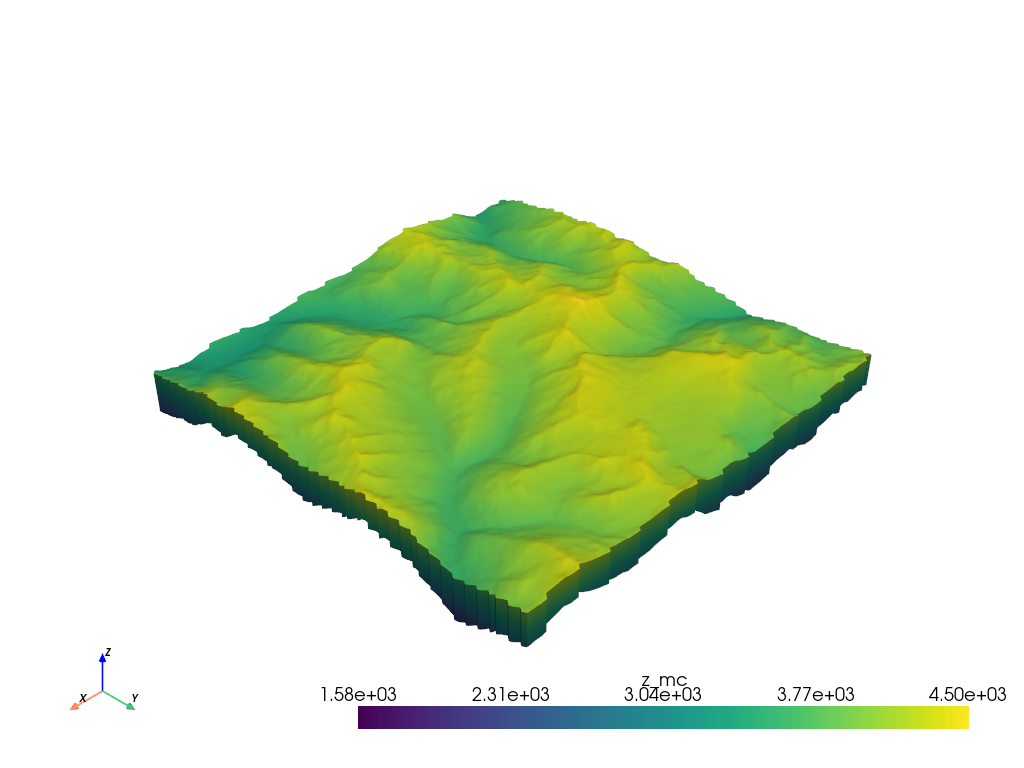

In [12]:
TS1.cmesh.plot()

## Generating A Time Series

To generate a time series, just call the  `.generate_time_series()` function from your object. You need to provide at least the variable name for which you want to generate the time series and the `plane_mode` argument. For this either use "surface" if you want to compute the time series on the ground or a height values (for example 2500) to use a plane generated at that height. Originally the `pv.slice` function was used. This though made it hard to add variables to the sliced geometry since it does not resemble the original mesh geometry which works with the new ICON.nc files. So either repeated slicing for every time step was necessary (which took about 15 seconds per time step). The second option used here it to generate a mask from the original mesh geometry at height x provided in the `plane_mode` argument. This approximates a planar slice but makes it possible to extract values at that height more quickly (4 seconds per time step). You can use the parameter `tolerance` to adjust what cells around the height x are included in the mask. If you want to limit the area for which the series is computed, also provide the `polygon` argument. Finally you can use the `value_limits` argument to exclude all cells outside of this interval from the computation. This is especially useful if you know that edge cells have zeros which should not be included. The return from this function is a pandas dataframe which can further be processed and automatically saved with the `save_as` argument.

In [13]:
# Test with surface temperature "t_sk"
df1 = TS1.generate_time_series(variable="t_sk", polygon=polygon, plane_mode="surface", value_limits=[1, np.inf])
print(df1.head(10))

100%|██████████| 6/6 [00:01<00:00,  4.45it/s]

                date        mean        var         min         max
0  20230829T04:00:00  274.076355   4.307427  266.025391  280.282074
1  20230829T05:00:00  273.993927   3.816371  266.875427  279.890259
2  20230829T06:00:00  274.121887   4.545573  266.779175  280.355438
3  20230829T07:00:00  274.550751   5.149509  270.901123  280.940765
4  20230829T08:00:00  274.932190   6.537007  272.161530  281.930756
5  20230829T09:00:00  275.937134  14.043332  272.890472  286.100708
6  20230829T10:00:00  276.574219  19.450382  272.907074  288.340240
7  20230829T11:00:00  277.264893  24.151720  272.922485  289.878113
8  20230829T12:00:00  277.576813  23.538851  273.051056  290.628937
9  20230829T13:00:00  277.828278  23.531477  273.048828  290.862091


**Not working yet**

In [14]:
# Test with temperature at 2500 meters
df2 = TS1.generate_time_series(variable="temp", plane_mode=2500, polygon=polygon, tolerance=20, value_limits=[1, np.inf])
print(df2.head(10))

100%|██████████| 6/6 [00:29<00:00,  4.94s/it]

                date        mean        var         min         max
0  20230829T04:00:00  230.910528  23.131366  223.472244  241.491119
1  20230829T05:00:00  230.690042  24.875798  223.947464  241.598007
2  20230829T06:00:00  230.462432  27.448381  224.018585  241.654800
3  20230829T07:00:00  230.396019  30.116128  223.254303  241.610794
4  20230829T08:00:00  230.375262  32.521030  222.444717  241.804886
5  20230829T09:00:00  230.274400  34.964719  221.714249  242.151108
6  20230829T10:00:00  230.196671  36.187482  221.469162  242.410385
7  20230829T11:00:00  230.100531  37.319703  221.645294  242.478241
8  20230829T12:00:00  229.962528  38.777980  221.257919  242.494308
9  20230829T13:00:00  229.834066  40.432212  220.904327  242.512375
